In [100]:
import random
import string
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   MinMaxScaler, 
                                   OrdinalEncoder,
                                   LabelEncoder)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import (GridSearchCV, 
                                     RandomizedSearchCV,
                                     cross_val_score)
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
import optuna
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report, 
                            confusion_matrix, 
                            f1_score, 
                            roc_auc_score)
from scipy.sparse import csr_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from optuna.integration import OptunaSearchCV
import shap
%matplotlib inline

In [101]:
data_samp = pd.read_csv('./datasets/kaggle_startups_sample_submit_28062024.csv')

In [102]:
data_test = pd.read_csv('./datasets/kaggle_startups_test_28062024.csv')

In [103]:
data_train = pd.read_csv('./datasets/kaggle_startups_train_28062024.csv')

In [104]:
data_train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


In [105]:
data_test.head(20)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,1.600000e+05,NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,2.684200e+07,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4.000000e+06,NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8.710000e+06,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,1.320000e+04,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


In [106]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


В тренировочном df 

- 4 колонки с датами указаны как object
- два столбца типа float
- остальные столбцы object (string)

In [107]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


В тестовом df 

- 4 колонки с датами указаны как object
- два столбца типа float
- остальные столбцы object (string)

In [108]:
print('city:',data_train.value_counts(['city']).unique().size)
print('region:',data_train.value_counts(['region']).unique().size)
print('country_code:',data_train.value_counts(['country_code']).unique().size)

city: 149
region: 147
country_code: 65


In [109]:
print('city:',data_test.value_counts(['city']).unique().size)
print('region:',data_test.value_counts(['region']).unique().size)
print('country_code:',data_test.value_counts(['country_code']).unique().size)

city: 78
region: 83
country_code: 50


In [110]:
# ProfileReport(data_samp, title="Profiling Report Samp")

В датафрейме samp хранятся значения таргета, имя - статус, никаких проблем, тут всё ок. 

Нужно будет совместить пропуски(если они будут в трейне и тесте), удалить или заполнить. решу позже.

In [111]:
# ProfileReport(data_train, title="Profiling Report")

Data_train:
- ***надо чекнуть на дубли***
1) name 
- 1 пропущенный 
- медианная длина названия 62 символа
- в среднем 12 букв в названии компании
2) category_list
- 2465 пропусков (4.7%)
- самые частые категории software (4.7%), biotechnology(2.7%), health(2.2%), media (2.1%)
3) funding_round_total
- 10069(19.2%) пропущены 
- среднее 18.247.481
- медиана 2.000.000
- 50% значений находятся в диапазоне от 336027.5 до 10.000.000
- IQR 9.663.972
- стандартное отклонение 1.87* 10^8
- есть очень большие значения,их мало, уберу их ниже
4) status тут все ок
5) country code 
- пропусков 10.5%(5502)
- самая часта usa( 63.2%)
6) state code 
- 6763(12.9%) пропущено
- самое частое : ca(10219),ny(3112),ma(2020),tx(1562)
7) region 
- 6359(12.1%) пропусков
8) city
- 6359(12.1%) пропущены 
9) funding rounds
- мин : 1, макс: 19
- бОльшая часть компаний имеет до 5 раундов
10) founded_at
- распределение с длинным левым концом, что говорит нам о том, что есть ряд компаний «старожил», большая же часть компаний была основана с 1998 по 2018
11) first_funding_at
- ситуация аналогична с founded at
12) last_funding_at
- ситуация аналогична c first_funding_at
13) closed_at
- распределение с exp ростом, с явным куполом в диапазоне 2008 - 2018
(основной срок закрытия , начиная скризиса и по последующие дни, исправив пропуски в этмо столцбе, количество компаний, закрывшихся 01-01-2018 увеличится, но исходная картина описанадо этого)

In [112]:
# ProfileReport(data_test, title="Profiling Report")

data_test:
- ***надо чекнуть на дубли***
1) name 
- пропусков нет
2) category_list
- 591 пропусков (4.5%)
- самые частые категории software (1217 4.6%), biotechnology (693 2.6%), health (589 2.2%), media (574 2.2%)
3) funding_round_total
- 2578(19.6%) пропущены 
- среднее 16.549.103
- медиана 2.000.000
- 50% значений находятся в диапазоне от 320000 до 10000000
- IQR 9.680.000
- стандартное отклонение 92.172.826
- есть очень большие значения,их мало, уберу их ниже(заполню медианой по их первой категории)
4) country code 
- пропусков 10.5%(1382)
- самая часта usa	(7428	63.3%)
6) state code 
- 1695(12.5%) пропущено
- самое частое : ca(10219),ny(3112),ma(2020),tx(1562)
7) region 
- 1589(12.1%) пропусков
8) city
- 1587(12.1%) пропусков
9) funding rounds
- мин : 1, макс: 19
- бОльшая часть компаний имеет до 5 раундов
10) founded_at
- распределение с длинным левым концом, что говорит нам о том, что есть ряд компаний «старожил», большая же часть компаний была основана с 1998 по 2018
11) first_funding_at
- ситуация аналогична с founded at
12) last_funding_at
- ситуация аналогична c first_funding_at
13) lifetime
- descr = (длительность жизни в днях, по - сути, это дата коцна - дата начала)
- смещение с длинным правым концом говорит о том, что лишь небольшое число компаний живут долго ( предположу, что их "капитализация" больше остальных)
- медиана 2526 дней
- среднее 3098 дней
- 50% компаний живут от 1726 до 3866 дней

## Обработка данных

In [113]:
# КОПИЯ DF ДЛЯ ПРОВЕРКИ РАБОТЫ НАШИХ ФУНКЦИЙ
train_copy = data_train.copy(deep=True)
test_copy = data_test.copy(deep=True)

In [114]:
# Список столбцов тренировочного и тестового датасетов
train_col_names = list(train_copy.columns)
test_col_names = list(test_copy .columns)
# Список датафреймов (тренировочный и тестовый)
data_names = dict(train_copy = train_copy, test_copy = test_copy)

**Дубликаты по train / test**

In [115]:
data_names['test_copy']['name'].duplicated().sum()

0

In [116]:
data_names['train_copy']['name'].duplicated().sum()

0

Явных удблей нет, все остальные колонки нет смысла смотреть, позже после преобразвоания данных проверим еще ра на явные дубли, для корректности merg'а

todo list:

для всех: 

- зfполнить пропуски индвидуально через func
- построить boxplot + hist для количественных
- построить bar + pie для категориальных 
- чекнуть на дубли
- чекнуть аномалии
- разобраться с category_list

train:
- добавить столбец lifetime (как дата закрытия - дата начала)

**Пропуски**

In [117]:
def check_isna():
    for i,data in data_names.items():
        print(f'\nВ {i}\n')
        for col in data.columns:
            missing_count = data[col].isna().sum()
            if missing_count > 0:
                print(f'В {col} {missing_count} пропусков')

In [118]:
check_isna()


В train_copy

В name 1 пропусков
В category_list 2465 пропусков
В funding_total_usd 10069 пропусков
В country_code 5502 пропусков
В state_code 6763 пропусков
В region 6359 пропусков
В city 6359 пропусков
В closed_at 47599 пропусков

В test_copy

В category_list 591 пропусков
В funding_total_usd 2578 пропусков
В country_code 1382 пропусков
В state_code 1695 пропусков
В region 1589 пропусков
В city 1587 пропусков


In [119]:
def generate_name(series):
    lowcase_letters = string.ascii_lowercase + string.ascii_uppercase# определяем алфавит из всех лат.букв lower+uppercase
    random_letters = ""
    values_array = series.values# получаем array значений столбца
    nan_indices = list(np.where(pd.isna(values_array))[0])# ищем индексы nan элементов в столбце
    new_series = series.copy()  # Создаем копию серии
    
    for i, elem in enumerate(series):
        if i in nan_indices:
            random_letters = "".join(random.choices(lowcase_letters, k=12))
            new_series.iloc[i] = random_letters  # Присваиваем значение в новой серии
    
    return new_series  # Возвращаем новую серию

In [120]:
data_names['train_copy']['name'] = generate_name(data_names['train_copy']['name'])

In [121]:
data_names['train_copy']['name'].isna().sum()

0

Теоретически, НЕуникальные значения появятся после того, как мы 52^12 = 390.877.006.486.250.192.896 раз сгенерируем имена/

Так что функция работате корректно

In [122]:
def fill_missing_funding(df, group_columns, target_column='funding_total_usd'):
    """
    Заполняет пропуски в столбце target_column на основе медианных значений для определённых групп.
    Если медиана для группы NaN, заполняет глобальной медианой.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    group_columns (list): Список столбцов, по которым группировать данные.
    target_column (str): Столбец с пропусками, которые нужно заполнить.
    
    Returns:
    pd.DataFrame: DataFrame с заполненными значениями.
    """
    
    # Создаем копию DataFrame, чтобы избежать изменений оригинала
    df_copy = df.copy()
    
    # Вычисляем глобальную медиану на случай, если группа не найдется или будет NaN
    global_median = df_copy[target_column].median()
    
    def fill_row(row):
        if pd.isnull(row[target_column]):
            # Ищем не пустые значения в столбцах группы
            for col in group_columns:
                if pd.notnull(row[col]):
                    # Группируем по текущему столбцу и заполняем медианой
                    group_median = df_copy.groupby(col)[target_column].transform('median')
                    
                    # Проверяем, является ли медиана для данной строки NaN
                    if pd.isna(group_median[row.name]):
                        continue
                    return group_median[row.name]
            
            # Если все столбцы группы пустые или медиана NaN, заполняем глобальной медианой
            return global_median
        else:
            return row[target_column]
    
    # Применяем функцию ко всем строкам DataFrame
    df_copy[target_column] = df_copy.apply(fill_row, axis=1)
    
    return df_copy

In [123]:
# train_copy_filled = fill_missing_funding(train_copy,['country_code','state_code','region','city','funding_rounds'])

In [124]:
# train_copy_filled['funding_total_usd'].isna().sum()

In [125]:
data_names['train_copy'] = fill_missing_funding(data_names['train_copy'],['country_code','state_code','region','city'])
data_names['test_copy'] = fill_missing_funding(data_names['test_copy'],['country_code','state_code','region','city'])

In [126]:
data_names['train_copy']['funding_total_usd'].isna().sum()

0

Теперь category_lsit

In [269]:
def generate_and_fill_embeddings(df, vector_size=5, window=5, min_count=1, workers=4):
    """
    Функция для создания и заполнения эмбеддингов для категорий.

    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    vector_size (int): Размер вектора эмбеддинга.
    window (int): Максимальное расстояние между текущим и предсказанным словом в предложении.
    min_count (int): Игнорировать все слова с общим количеством вхождений ниже этого значения.
    workers (int): Количество потоков для обучения модели.

    Returns:
    pd.DataFrame: DataFrame с эмбеддингами в виде отдельных столбцов.
    """
    
    # Шаг 1: Замена NaN на 'other'
    df['category_list'] = df['category_list'].fillna('other')
    
    # Шаг 2: Разделение категорий по '|'
    categories_split = df['category_list'].apply(lambda x: str(x).split('|'))
    
    # Шаг 3: Обучение модели Word2Vec на всех категориях
    model = Word2Vec(sentences=categories_split, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
    # Шаг 4: Функция для получения среднего эмбеддинга для списка категорий
    def get_mean_embedding(categories, model):
        embeddings = [model.wv[category] for category in categories if category in model.wv]
        if len(embeddings) > 0:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(model.vector_size)
    
    # Шаг 5: Применение функции ко всем записям и создание DataFrame
    embeddings = categories_split.apply(lambda x: get_mean_embedding(x, model))
    embeddings_df = pd.DataFrame(embeddings.tolist(), columns=[f'e_{i}' for i in range(vector_size)], index=df.index)
    # Объединение исходного DataFrame с эмбеддингами
    df = pd.concat([df, embeddings_df], axis=1)
    
    return df.drop(columns=['category_list'])


In [266]:
def generate_and_fill_embeddings(df, vector_size=5, window=5, min_count=1, workers=4):
    """
    Функция для создания и заполнения эмбеддингов для категорий.

    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    vector_size (int): Размер вектора эмбеддинга.
    window (int): Максимальное расстояние между текущим и предсказанным словом в предложении.
    min_count (int): Игнорировать все слова с общим количеством вхождений ниже этого значения.
    workers (int): Количество потоков для обучения модели.

    Returns:
    pd.DataFrame: DataFrame с эмбеддингами в виде отдельных столбцов.
    """
    
    # Шаг 1: Замена NaN на 'other'
    df['category_list'] = df['category_list'].fillna('other')
    
    # Шаг 2: Разделение категорий по '|'
    categories_split = df['category_list'].apply(lambda x: str(x).split('|'))
    
    # Шаг 3: Обучение модели Word2Vec на всех категориях
    model = Word2Vec(sentences=categories_split, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
    # Шаг 4: Функция для получения среднего эмбеддинга для списка категорий
    def get_mean_embedding(categories, model):
        embeddings = [model.wv[category] for category in categories if category in model.wv]
        if len(embeddings) > 0:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(model.vector_size)
    
    # Шаг 5: Применение функции ко всем записям и создание DataFrame
    embeddings = categories_split.apply(lambda x: get_mean_embedding(x, model))
    embeddings_df = pd.DataFrame(embeddings.tolist(), columns=[f'e_{i}' for i in range(vector_size)], index=df.index)
    
    # Убедимся, что индексы совпадают перед объединением
    assert df.index.equals(embeddings_df.index), "Индексы DataFrame не совпадают после создания эмбеддингов!"
    
    # Объединение исходного DataFrame с эмбеддингами
    df = pd.concat([df, embeddings_df], axis=1)
    
    return df.drop(columns=['category_list'])

In [268]:
data_names['train_copy'] = generate_and_fill_embeddings(data_names['train_copy'])

KeyError: 'category_list'

In [ ]:
data_names['train_copy']

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,e_0,e_1,e_2,e_3,e_4,dur_betw_rounds
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,-0.113425,1.492333,0.974639,-0.919291,0.153202,1310
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,1.105726,-0.024615,3.127274,-0.725179,0.583867,1393
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,1.542596,-0.089559,2.770891,-0.674394,0.304015,681
3,Sancilio and Company,22250000.0,operating,USA,CA,SF Bay Area,San Francisco,3,1.239941,-0.052970,3.750900,-0.697964,0.674914,1051
4,WireTough Cylinders,3000000.0,operating,USA,VA,VA - Other,Bristol,1,0.153772,0.153893,2.299073,-0.397540,0.328512,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,2000000.0,operating,CAN,ON,Toronto,Kitchener,1,1.630039,3.093513,0.447410,-1.336378,0.069129,0
52512,Hello Curry,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,-0.010886,1.065458,1.108076,-1.484071,0.597488,0
52513,Taskforce,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,-0.266229,1.594291,0.509434,-0.711104,-1.921736,566
52514,NetScaler,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,0.279126,-0.031514,1.695941,-0.060535,-1.606405,1918


In [130]:
data_names['test_copy']= generate_and_fill_embeddings(data_names['test_copy'])

Теперь заполним пропуски по регионам

In [131]:
train_copy.loc[(train_copy['region'].isna()==True)&
               (train_copy['state_code'].isna()==True)&
               (train_copy['country_code'].isna()==True)&
               (train_copy['city'].isna()==True),'name'].size

5502

In [205]:
train_copy[(train_copy['region'].isna()==True)&
               (train_copy['state_code'].isna()==True)&
               (train_copy['country_code'].isna()==True)&
               (train_copy['city'].isna()==True)]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-04-06,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52444,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-05-05
52449,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-01-25,2000-10-23,2000-10-23,2002-05-17
52455,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2014-11-15,2015-09-29,2015-09-29,2017-04-24
52473,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-01-10,1999-11-02,1999-11-02,NaN


5502 строки с пропусками в географических столбцах, грустно.

In [133]:
def fill_geographical_columns(df, geo_columns):
#     """
#     Функция для заполнения географических столбцов, сначала на основе заполненных значений,
#     затем модой по каждому столбцу для строк, где все значения NaN. В завершении заполняет
#     оставшиеся исключительные случаи значением 'unknown'.
    
#     Parameters:
#     df (pd.DataFrame): DataFrame с данными.
#     geo_columns (list): Список столбцов с географической информацией.
    
#     Returns:
#     pd.DataFrame: DataFrame с заполненными значениями для географических столбцов.
#     """
    
    df_copy = df.copy()  # Создаем копию, чтобы избежать изменений в оригинальном DataFrame
    
    # Шаг 1: Заполнение пропусков, где хотя бы одно значение не NaN
    for col in geo_columns:
        for ref_col in geo_columns:
            if col != ref_col:
                # Заполняем пропуски в столбце col на основе моды для ref_col
                    mode_values = df_copy.groupby(ref_col)[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
                    df_copy.fillna({col:mode_values}, inplace=True)
    
   # Шаг 2: Заполнение строк, где все значения NaN
    most_frequent_values = {col: df_copy[col].mode()[0] for col in geo_columns if df_copy[col].mode().size > 0}
    
    def fill_row(row):
        if row[geo_columns].isna().all():
            for col in geo_columns:
                row[col] = most_frequent_values.get(col, 'unknown')  # Заполняем модой или 'unknown'
        return row
    
    df_copy = df_copy.apply(fill_row, axis=1)
    
     # Шаг 3: Обработка исключительных случаев, оставшихся после всех предыдущих шагов
    for col in geo_columns:
       df_copy.fillna({col:'unknown'}, inplace=True)
  
    return df_copy

In [134]:
geo_columns = ['city','country_code','state_code','region']

In [135]:
train_copy_geo = data_names['train_copy'].copy(deep = True)
train_copy_geo = fill_geographical_columns(train_copy_geo,geo_columns)

C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mode_values = df_copy.groupby(ref_col)[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mode_values = df_copy.groupby(ref_col)[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object d

In [136]:
# Проверка заполненных значений
train_copy_geo.isna().sum()

name                     0
funding_total_usd        0
status                   0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
e_0                      0
e_1                      0
e_2                      0
e_3                      0
e_4                      0
dtype: int64

In [137]:
data_names['train_copy'] = fill_geographical_columns(data_names['train_copy'],geo_columns)

C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mode_values = df_copy.groupby(ref_col)[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mode_values = df_copy.groupby(ref_col)[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object d

In [138]:
data_names['test_copy'] = fill_geographical_columns(data_names['test_copy'],geo_columns)

C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mode_values = df_copy.groupby(ref_col)[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mode_values = df_copy.groupby(ref_col)[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object d

In [139]:
check_isna()


В train_copy

В closed_at 47599 пропусков

В test_copy



Теперь даты 

In [259]:
import pandas as pd

def process_date_columns(df, date_columns):
    """
    Функция для обработки датовых столбцов, извлечения года, месяца и дня,
    проверки пропусков и аномалий, и их заполнения.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    date_columns (list): Список столбцов с датами.
    
    Returns:
    pd.DataFrame: DataFrame с обработанными датовыми столбцами.
    """
    
    # Преобразуем строки в datetime, если столбец существует
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')
    
    # Заполнение пропусков
    if 'first_funding_at' in df.columns and 'founded_at' in df.columns:
        df.fillna({'first_funding_at': df['founded_at']}, inplace=True)
    
    if 'last_funding_at' in df.columns:
        df.fillna({'last_funding_at':pd.Timestamp('2018-01-01')}, inplace=True)
    
    if 'closed_at' in df.columns:
        df.fillna({'closed_at':pd.Timestamp('2018-01-01')}, inplace=True)
    
    if 'founded_at' in df.columns:
        # Если founded_at пропущен, заполняем по медиане категорий
        overall_median_founded_at = df['founded_at'].median()
        df['founded_at'].fillna(overall_median_founded_at, inplace=True)
    
    # Проверка и исправление аномалий
    if 'first_funding_at' in df.columns and 'last_funding_at' in df.columns:
        df.loc[df['first_funding_at'] > df['last_funding_at'], ['first_funding_at', 'last_funding_at']] = \
            df.loc[df['first_funding_at'] > df['last_funding_at'], ['last_funding_at', 'first_funding_at']].values
    
    if 'first_funding_at' in df.columns and 'last_funding_at' in df.columns:
        df['dur_betw_rounds'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
    # # Извлечение года, месяца и дня из дат
    # if 'founded_at' in df.columns:
    #     df['founded_year'] = df['founded_at'].dt.year
    #     df['founded_month'] = df['founded_at'].dt.month
    #     df['founded_day'] = df['founded_at'].dt.day
    
    # if 'first_funding_at' in df.columns:
    #     df['first_year'] = df['first_funding_at'].dt.year
    #     df['first_month'] = df['first_funding_at'].dt.month
    #     df['first_day'] = df['first_funding_at'].dt.day
    
    # if 'last_funding_at' in df.columns:
    #     df['last_year'] = df['last_funding_at'].dt.year
    #     df['last_month'] = df['last_funding_at'].dt.month
    #     df['last_day'] = df['last_funding_at'].dt.day
    
    # # Создание столбца lifetime
    # if 'closed_at' in df.columns and 'founded_at' in df.columns:
    #     df['lifetime'] = (df['closed_at'] - df['founded_at']).dt.days
    
    # Удаление ненужных столбцов
    columns_to_drop = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    
    return df


In [150]:
train_copy_date = train_copy.copy(deep = True)
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']


In [153]:
train_copy_date = process_date_columns(data_names['train_copy'],date_columns)
test_copy_date = process_date_columns(data_names['test_copy'],date_columns)

In [154]:
check_isna()


В train_copy


В test_copy



In [155]:
train_copy_date

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,e_0,e_1,e_2,e_3,e_4,dur_betw_rounds
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,-0.113425,1.492333,0.974639,-0.919291,0.153202,1310
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,1.105726,-0.024615,3.127274,-0.725179,0.583867,1393
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,1.542596,-0.089559,2.770891,-0.674394,0.304015,681
3,Sancilio and Company,22250000.0,operating,USA,CA,SF Bay Area,San Francisco,3,1.239941,-0.052970,3.750900,-0.697964,0.674914,1051
4,WireTough Cylinders,3000000.0,operating,USA,VA,VA - Other,Bristol,1,0.153772,0.153893,2.299073,-0.397540,0.328512,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,2000000.0,operating,CAN,ON,Toronto,Kitchener,1,1.630039,3.093513,0.447410,-1.336378,0.069129,0
52512,Hello Curry,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,-0.010886,1.065458,1.108076,-1.484071,0.597488,0
52513,Taskforce,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,-0.266229,1.594291,0.509434,-0.711104,-1.921736,566
52514,NetScaler,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,0.279126,-0.031514,1.695941,-0.060535,-1.606405,1918


In [156]:
test_copy_date

,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,lifetime,e_0,e_1,e_2,e_3,e_4,dur_betw_rounds
0,Crystalsol,2819200.0,NIC,17,Copenhagen,Copenhagen,1,3501,0.081480,0.543031,1.482921,-1.246891,-0.279989,0
1,JBI Fish & Wings,3000000.0,USA,TN,TN - Other,Humboldt,1,2717,-0.293797,0.629190,1.388575,-1.113982,-0.329796,0
2,COINPLUS,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,1295,-0.129839,0.908528,1.638074,-0.843074,-0.633328,126
3,Imagine Communications,34700000.0,USA,CA,San Diego,San Diego,4,4748,-0.027602,0.636687,1.616821,-1.006429,-0.355801,1935
4,DNA13,4530000.0,CAN,ON,Ottawa,Ottawa,1,6209,-0.085907,0.713759,1.686561,-1.064412,-0.645288,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2267,-0.362419,0.869630,1.237509,-1.069276,-0.651592,0
13121,GlobaTrek,3000000.0,USA,CA,SF Bay Area,Mountain View,1,2192,-0.085907,0.713759,1.686561,-1.064412,-0.645288,0
13122,Inkd.com,5600000.0,USA,WA,Seattle,Seattle,3,2922,-0.060406,0.608825,1.395887,-1.021046,-0.385225,1030
13123,AdWill,150000.0,USA,NY,New York City,New York,2,1386,-0.145258,0.465444,1.046143,-0.919581,-0.233864,38


In [159]:
train_copy_date.isna().sum()

name                 0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
e_0                  0
e_1                  0
e_2                  0
e_3                  0
e_4                  0
dur_betw_rounds      0
dtype: int64

In [ ]:
check_isna()


В train_copy


В test_copy



Ну и дропну потом lifetime 

# EDA

In [48]:
data_names['train_copy'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  52516 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   state_code         52516 non-null  object 
 6   region             52516 non-null  object 
 7   city               52516 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   e_0                52516 non-null  float64
 10  e_1                52516 non-null  float64
 11  e_2                52516 non-null  float64
 12  e_3                52516 non-null  float64
 13  e_4                52516 non-null  float64
 14  dur_betw_rounds    52516 non-null  int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 6.0+ MB


In [49]:
data_names['test_copy'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   lifetime           13125 non-null  int64  
 9   e_0                13125 non-null  float64
 10  e_1                13125 non-null  float64
 11  e_2                13125 non-null  float64
 12  e_3                13125 non-null  float64
 13  e_4                13125 non-null  float64
 14  dur_betw_rounds    13125 non-null  int64  
dtypes: float64(6), int64(3), object(6)
memory usage: 1.5+ MB


In [50]:
data_names['train_copy'].describe()

,funding_total_usd,funding_rounds,e_0,e_1,e_2,e_3,e_4,dur_betw_rounds
count,5.251600e+04,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000,52516.000000
mean,1.523701e+07,1.740670,0.121055,0.852104,1.187894,-0.864152,-0.666624,346.488994
std,1.683399e+08,1.374522,0.763529,0.913768,0.806112,0.645960,0.918829,688.604389
min,1.000000e+00,1.000000,-2.299495,-1.732921,-0.481317,-3.661169,-3.653449,0.000000
25%,5.000000e+05,1.000000,-0.237943,0.129670,0.656613,-1.116776,-1.324542,0.000000
50%,2.200000e+06,1.000000,0.146235,0.569118,0.991035,-0.831777,-0.568661,0.000000
75%,7.000000e+06,2.000000,0.402154,1.392999,1.520785,-0.437282,0.126290,427.000000
max,3.007950e+10,19.000000,2.123450,4.730649,3.605732,1.235714,1.613459,10807.000000


In [51]:
data_names['test_copy'].describe()

,funding_total_usd,funding_rounds,lifetime,e_0,e_1,e_2,e_3,e_4,dur_betw_rounds
count,1.312500e+04,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000,13125.000000
mean,1.379177e+07,1.714438,3097.609524,-0.045738,0.513009,1.293658,-0.952563,-0.290021,328.339962
std,8.281655e+07,1.318800,2128.356554,0.104744,0.199460,0.392697,0.287496,0.163804,658.073065
min,1.000000e+00,1.000000,52.000000,-0.341301,-0.167572,-0.181350,-1.533888,-0.712826,0.000000
25%,5.000000e+05,1.000000,1726.000000,-0.121378,0.406238,1.072862,-1.138872,-0.395416,0.000000
50%,2.000000e+06,1.000000,2526.000000,-0.055905,0.530407,1.375121,-1.030601,-0.267789,0.000000
75%,7.000000e+06,2.000000,3866.000000,0.022515,0.662441,1.584918,-0.828128,-0.185447,391.000000
max,4.715000e+09,15.000000,17167.000000,0.219450,0.948080,1.909581,0.077431,0.165030,7038.000000


funding_total_usd:

- В обеих выборках среднее значение финансирования составляет около $15.2 млн (трейн) и $13.8 млн (тест).
- Очень высокое стандартное отклонение (около $168 млн для трейн и $82.8 млн для теста), что указывает на наличие значительных выбросов.
- Минимальные значения финансирования всего $1, максимальные - более $30 млрд (трейн) и $4.7 млрд (тест), что подтверждает гипотезу о выбросах.

funding_rounds:

- Около 1.74 для трейн и 1.71 для теста. Это говорит о том, что большинство стартапов привлекают финансирование в 1-2 раундах.
- Максимальное количество раундов: 19 (трейн) и 15 (тест), что является значительным отклонением от медианных значений.

Временные признаки (first_year, last_year, lifetime):

- Средний год первого раунда - 2011 в обеих выборках, с некоторыми стартапами, которые начали получать финансирование еще в 1970-х годах.
- Средний год последнего раунда - 2012 (трейн) и 2011 (тест). Это соответствует срокам жизни стартапов.
- Средний срок жизни стартапа составляет около 3140 дней (трейн) и 3097 дней (тест), что примерно соответствует 8-9 годам. 
- Стандартное отклонение также велико, что указывает на значительные различия в сроках жизни компаний.


- Минимальное значение lifetime составляет всего 19 дней (трейн) и 52 дня (тест), что может указывать на быстрое закрытие некоторых стартапов.
- Максимальное значение lifetime составляет 17378 дней (трейн) и 17167 дней (тест), что может указывать на стартапы, которые существовали более 47 лет.

In [52]:
def plot_numeric_distributions(df, numeric_columns):
    """
    Функция для построения гистограмм и boxplot для всех числовых переменных в DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    numeric_columns (list): Список числовых столбцов, для которых нужно построить графики.
    
    Returns:
    list: Список объектов matplotlib Figure для каждого графика.
    """
    
    # Устанавливаем стиль для графиков
    sns.set(style="whitegrid")
    
    figures = []  # Список для хранения объектов Figure
    
    for col in numeric_columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Гистограмма
        sns.histplot(df[col], bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Boxplot of {col}')
        axes[1].set_xlabel(col)
        
        figures.append(fig)  # Добавляем объект Figure в список

    return figures
numeric_columns = ['funding_total_usd', 'funding_rounds','dur_betw_rounds']

In [225]:
data_names['train_copy'].isna().sum()

name                 0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
e_0                  0
e_1                  0
e_2                  0
e_3                  0
e_4                  0
dur_betw_rounds      0
dtype: int64

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\3059843018.py:5: UserWarning: FigureCanvasAgg is non-interacti

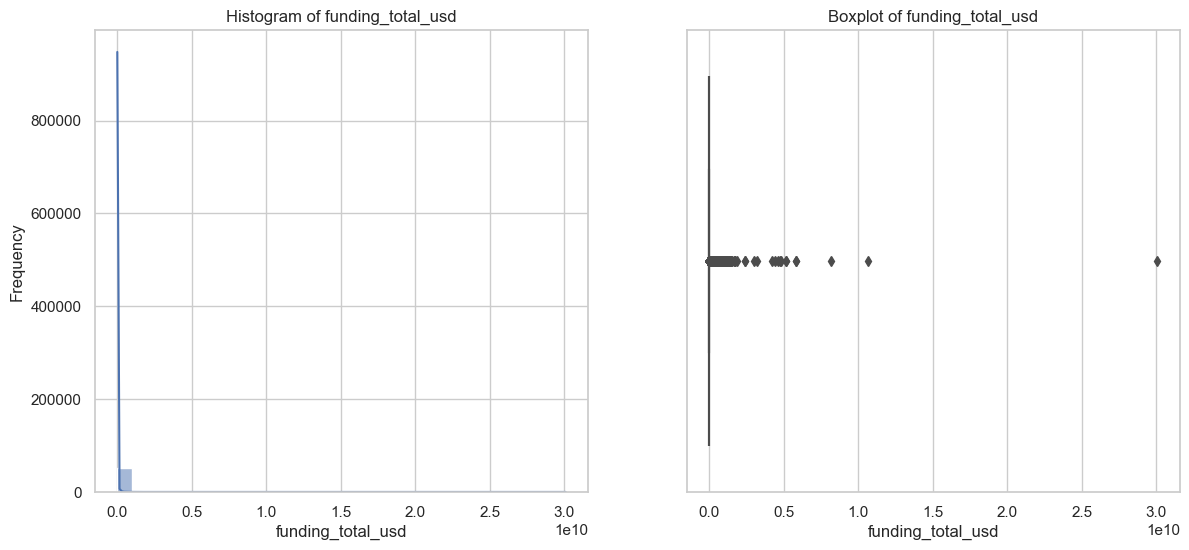

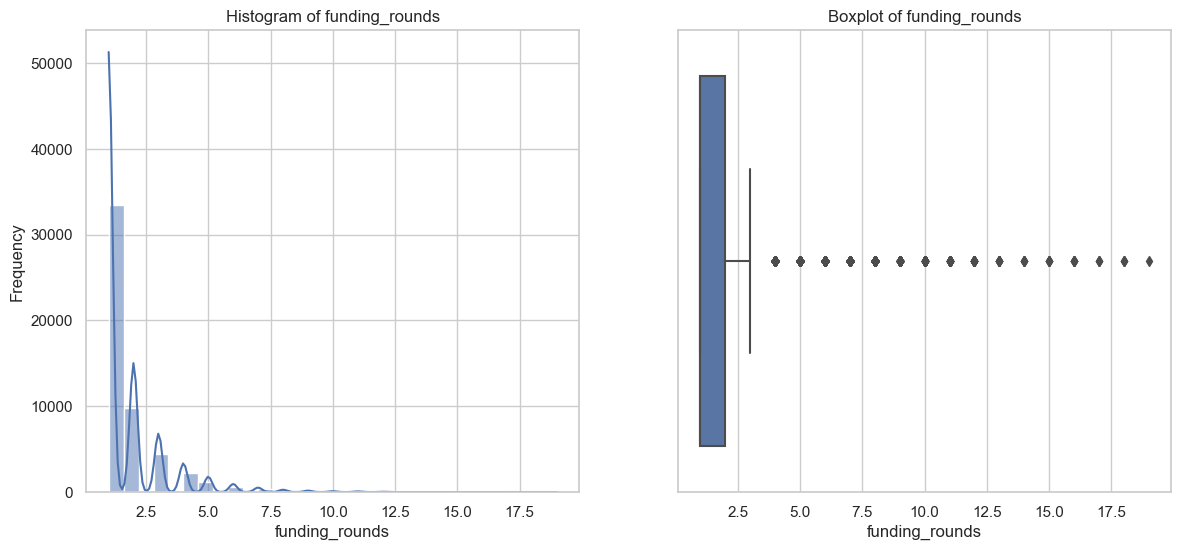

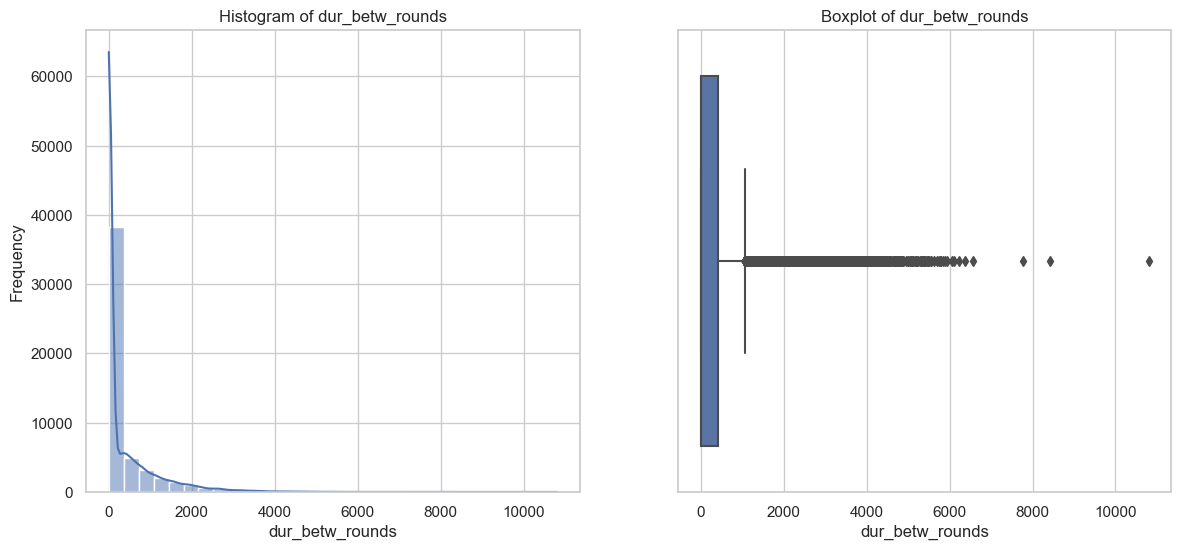

In [54]:
# Вызов функции
figures_train = plot_numeric_distributions(data_names['train_copy'], numeric_columns)

for fig in figures_train:
    fig.show()

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\4212507797.py:5: UserWarning: FigureCanvasAgg is non-interacti

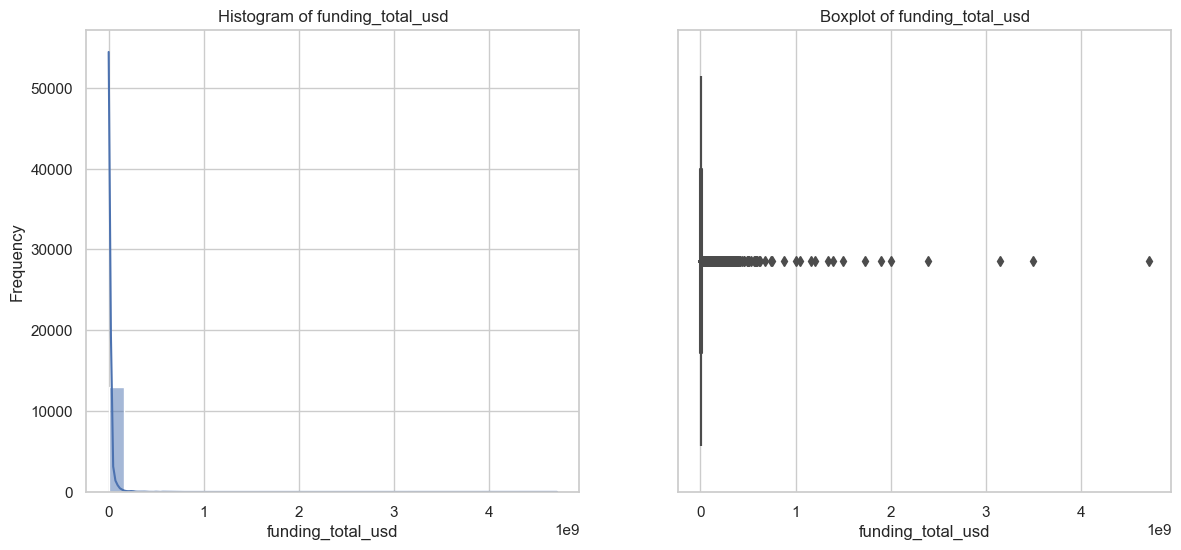

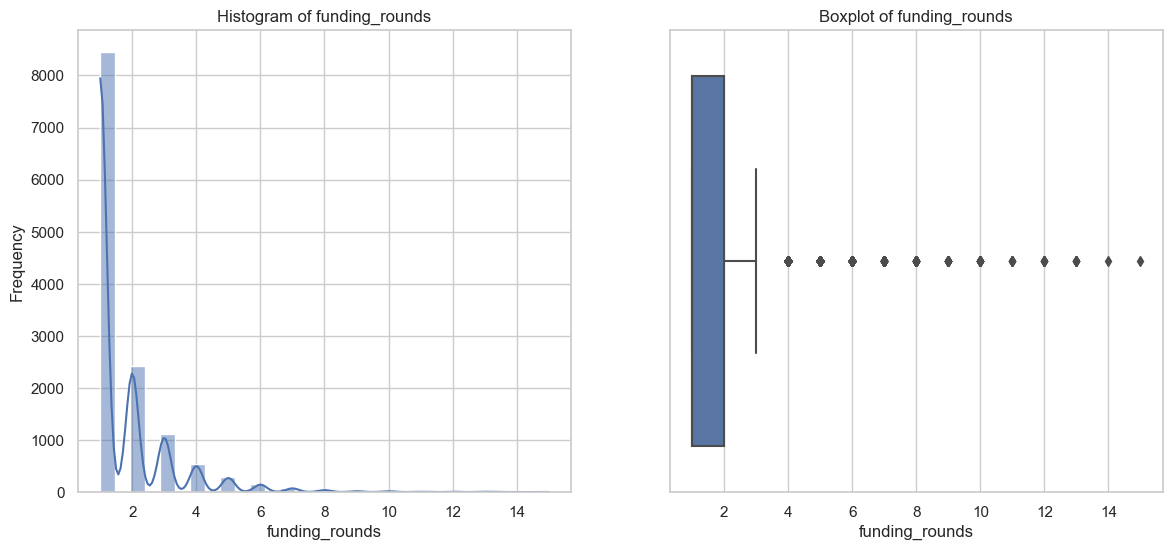

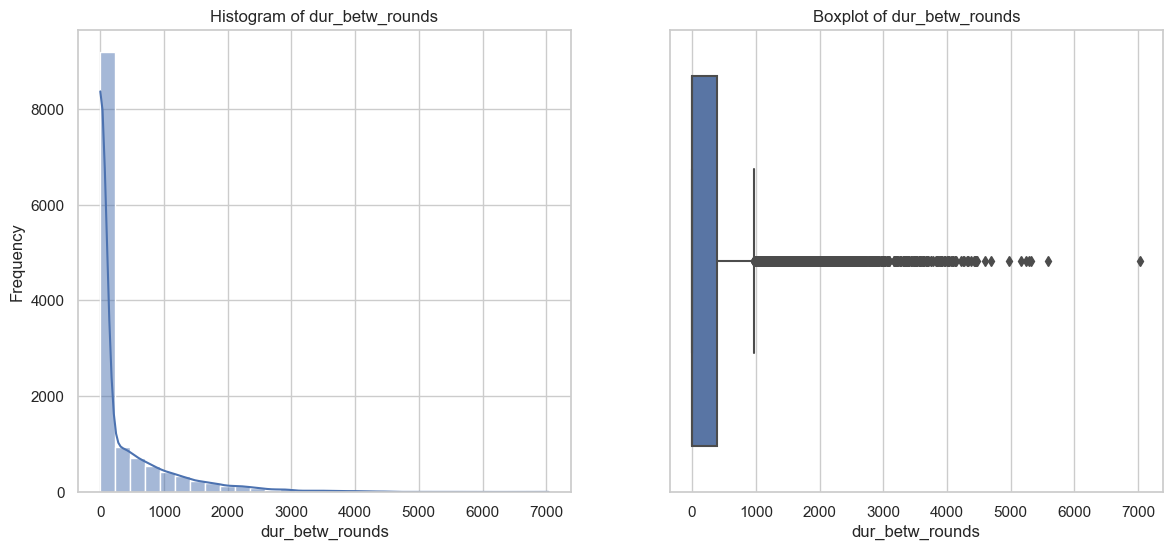

In [55]:
# Вызов функции
figures_test = plot_numeric_distributions(data_names['test_copy'], numeric_columns)

for fig in figures_test:
    fig.show()

In [56]:
def winsorize_column(df, column_name, lower_quantile=0.15, upper_quantile=0.85):
    """
    Функция для винсоризации столбца в DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    column_name (str): Название столбца, который нужно винсоризировать.
    lower_quantile (float): Нижняя граница процентиля (по умолчанию 1%).
    upper_quantile (float): Верхняя граница процентиля (по умолчанию 99%).
    
    Returns:
    pd.DataFrame: DataFrame с винсоризованным столбцом.
    """
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)

    df[column_name] = np.where(df[column_name] < lower_bound, lower_bound, 
                               np.where(df[column_name] > upper_bound, upper_bound, df[column_name]))
    return df


In [57]:
for key, df in data_names.items():
    data_names[key] = winsorize_column(df, 'funding_total_usd')

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\3059843018.py:5: UserWarning: FigureCanvasAgg is non-interacti

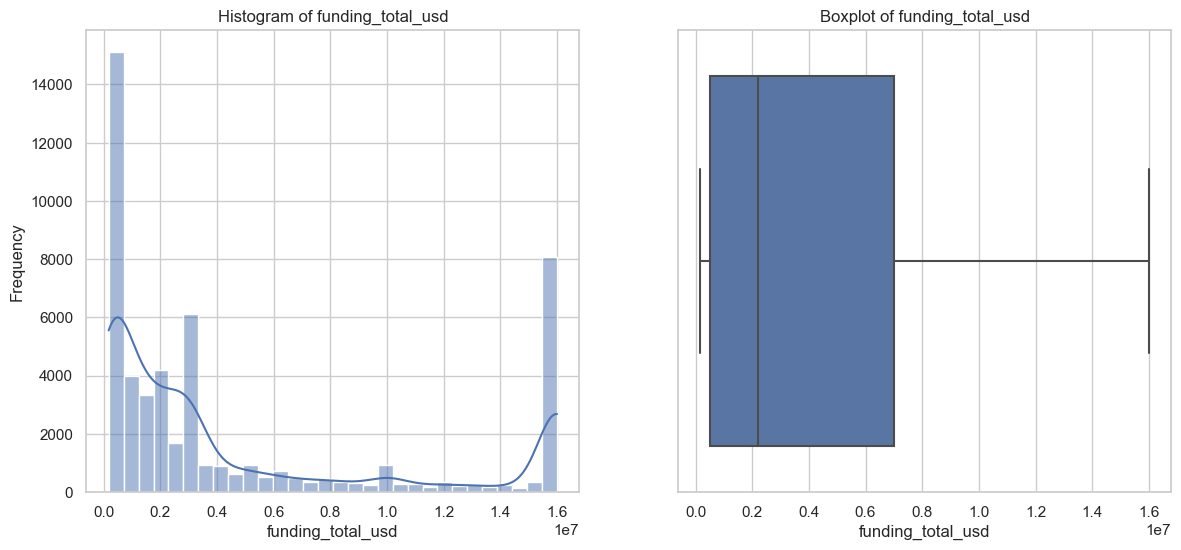

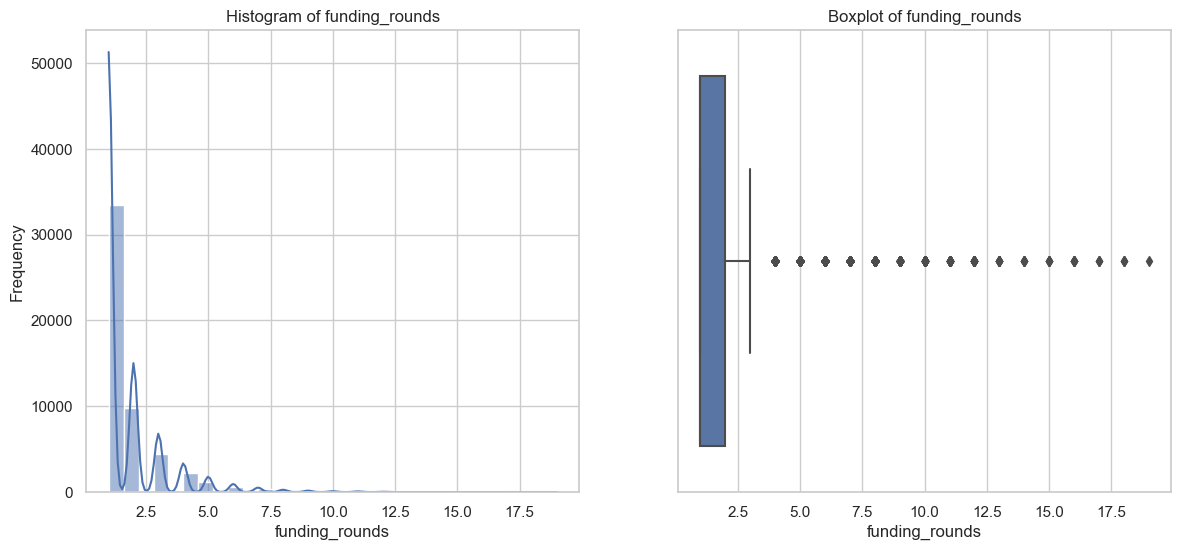

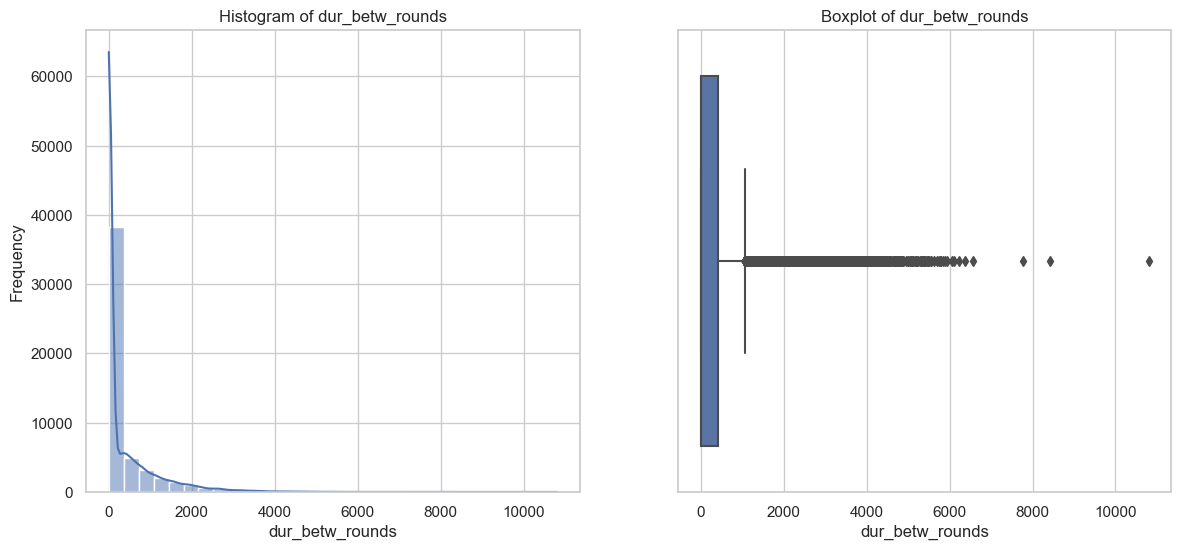

In [58]:
# Вызов функции
figures_train = plot_numeric_distributions(data_names['train_copy'], numeric_columns)

for fig in figures_train:
    fig.show()

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\4212507797.py:5: UserWarning: FigureCanvasAgg is non-interacti

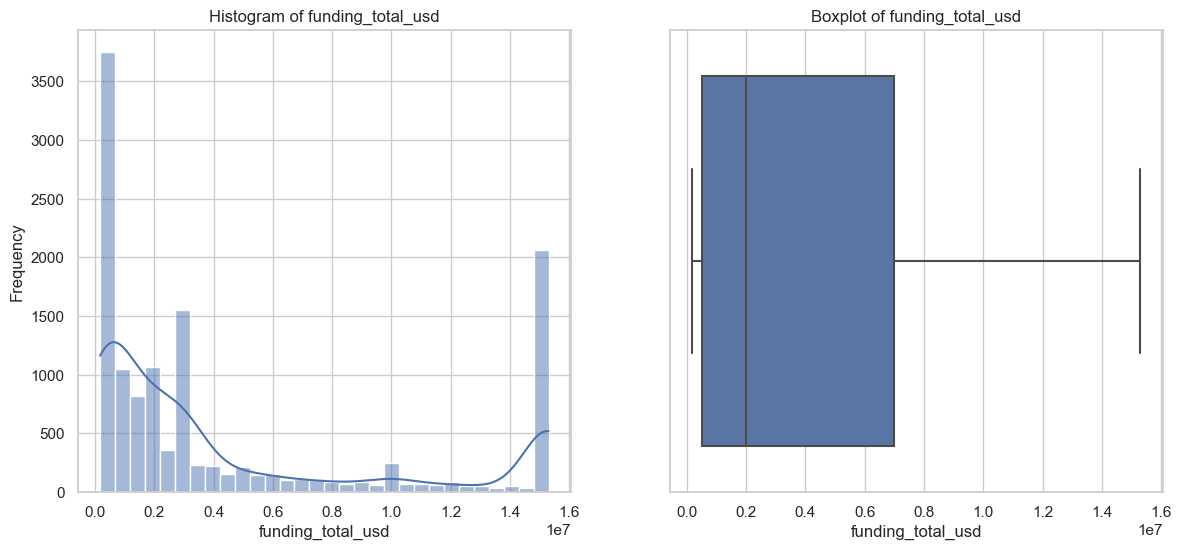

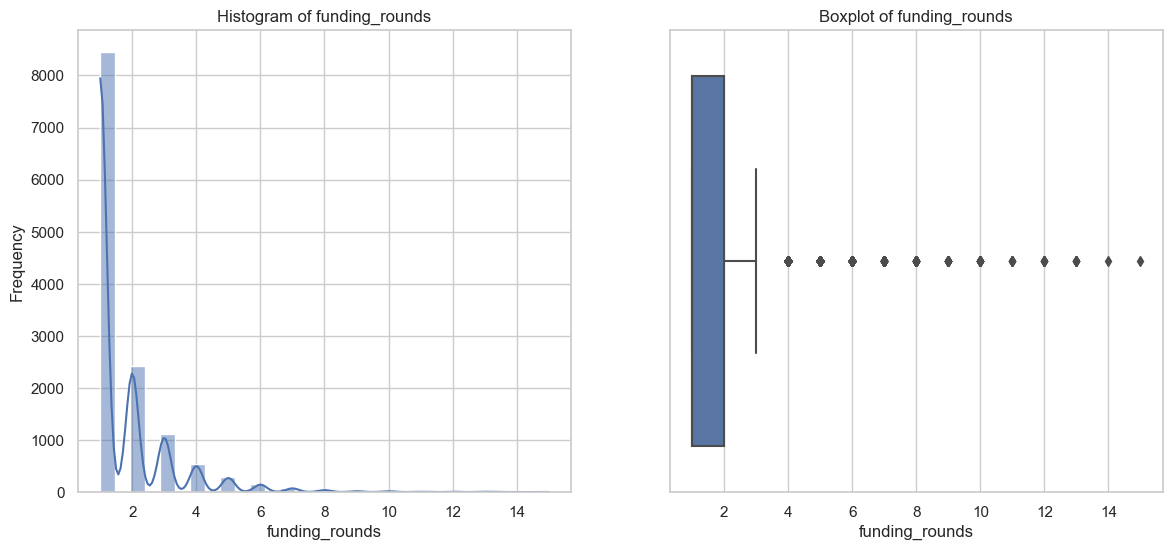

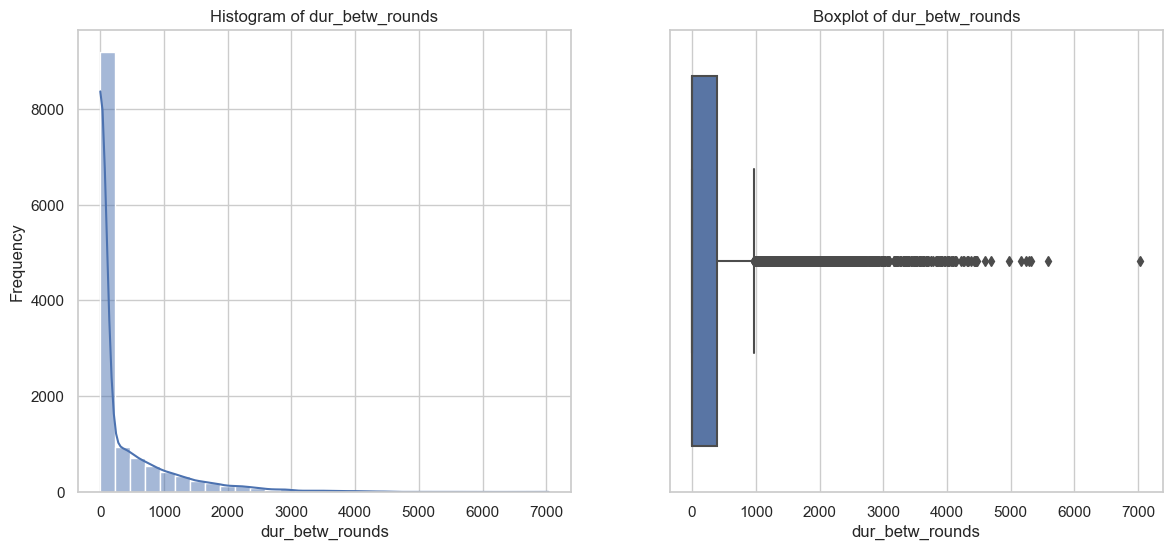

In [59]:
# Вызов функции
figures_test = plot_numeric_distributions(data_names['test_copy'], numeric_columns)

for fig in figures_test:
    fig.show()

- Распределение данных по funding_total_usd остается сильно скошенным вправо. 

- Большая часть значений сконцентрирована на нижних значениях, с небольшим количеством компаний, получивших очень большое финансирование.

- Большинство стартапов имеют один или два раунда финансирования, и распределение также имеет длинный хвост с небольшим количеством стартапов, имеющих большое число раундов.

- Распределение lifetime также скошено вправо, с большим количеством стартапов, которые закрылись в первые несколько лет, и с небольшим количеством долгоживущих стартапов.

Создадим класс, который будет преобразовывать число раундов финансирования в категориальные бины.

In [60]:
class FundingRoundsBinner(BaseEstimator, TransformerMixin):
    def __init__(self, column='funding_rounds'):
        self.column = column

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.column] = pd.cut(X_transformed[self.column], 
                                            bins=[-1, 0, 2, 4, np.inf], 
                                            labels=['0', '1-2', '3-4', '5+'])
        return X_transformed

In [61]:
data_names['train_copy']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,e_0,e_1,e_2,e_3,e_4,dur_betw_rounds
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,-0.351807,1.497126,1.049809,-0.824562,0.173264,1310
1,EarLens,Manufacturing|Medical|Medical Devices,16000000.00,operating,USA,CA,SF Bay Area,Redwood City,4,1.370847,0.173515,2.959829,-0.884385,0.621324,1393
2,Reviva Pharmaceuticals,Biotechnology,16000000.00,operating,USA,CA,SF Bay Area,San Jose,3,1.714194,0.129670,2.609024,-0.866563,0.324463,681
3,Sancilio and Company,Health Care,16000000.00,operating,USA,CA,SF Bay Area,San Francisco,3,1.394429,-0.071973,3.605732,-1.098824,0.739180,1051
4,WireTough Cylinders,Manufacturing,3000000.00,operating,USA,VA,VA - Other,Bristol,1,0.270902,0.366337,2.256096,-0.378956,0.325447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,2000000.00,operating,CAN,ON,Toronto,Kitchener,1,1.244330,3.280152,0.366576,-1.200139,-0.131111,0
52512,Hello Curry,Hospitality,500000.00,operating,IND,2,Hyderabad,Hyderabad,1,-0.068941,1.282109,1.340162,-1.203620,0.637306,0
52513,Taskforce,Email|Messaging|Productivity Software,172850.75,operating,USA,CA,SF Bay Area,San Francisco,3,-0.219005,1.382196,0.451554,-0.761389,-2.041054,566
52514,NetScaler,Security,13000000.00,operating,USA,CA,SF Bay Area,San Jose,6,0.566500,0.008172,1.651052,-0.025695,-1.661142,1918



Построение графиков для train_copy


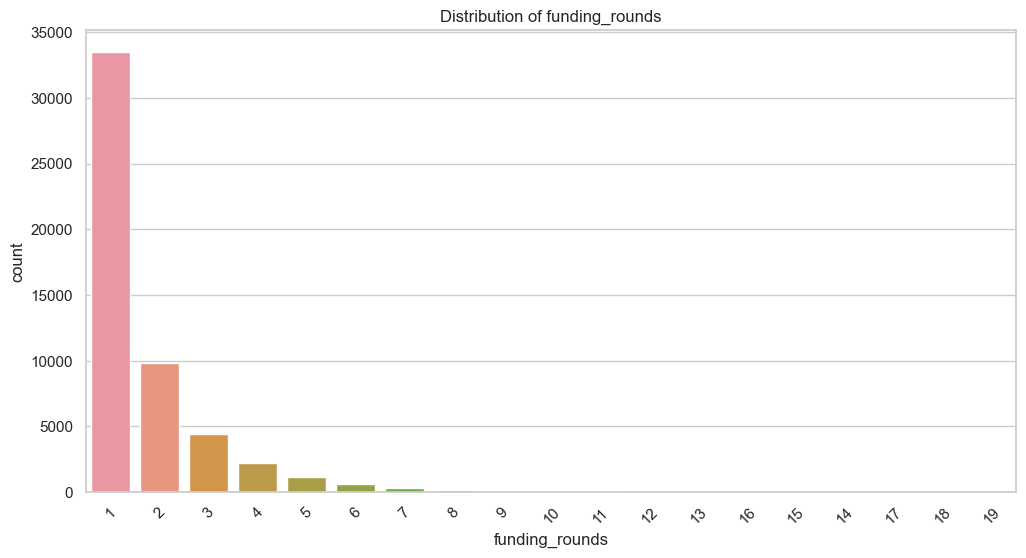

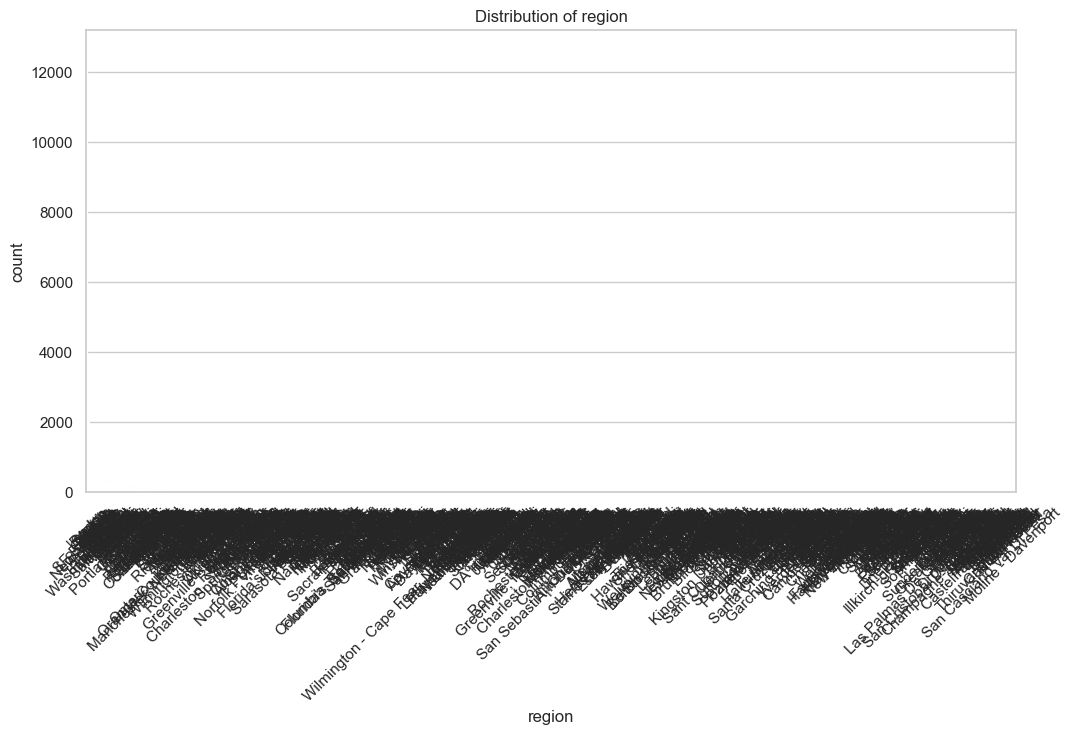


Построение графиков для test_copy


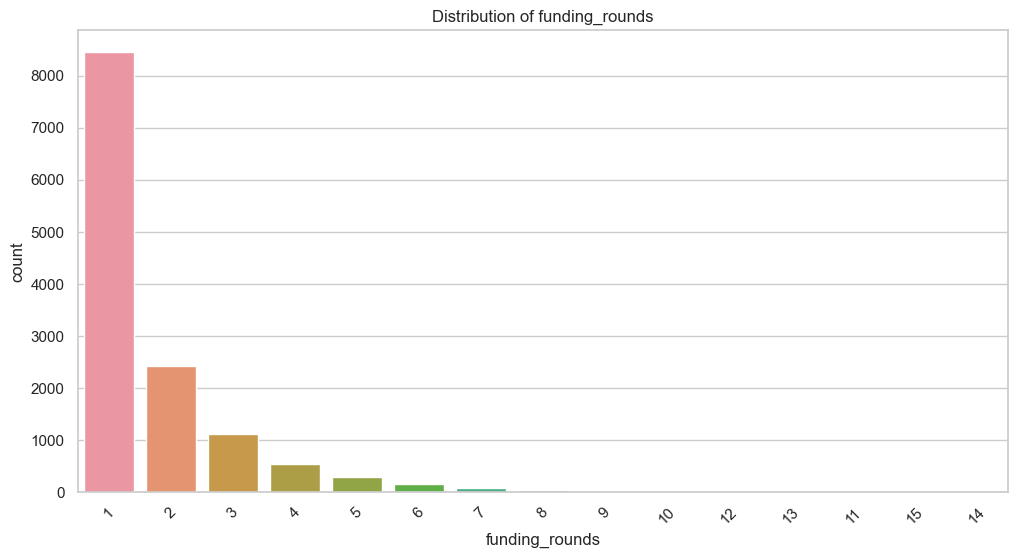

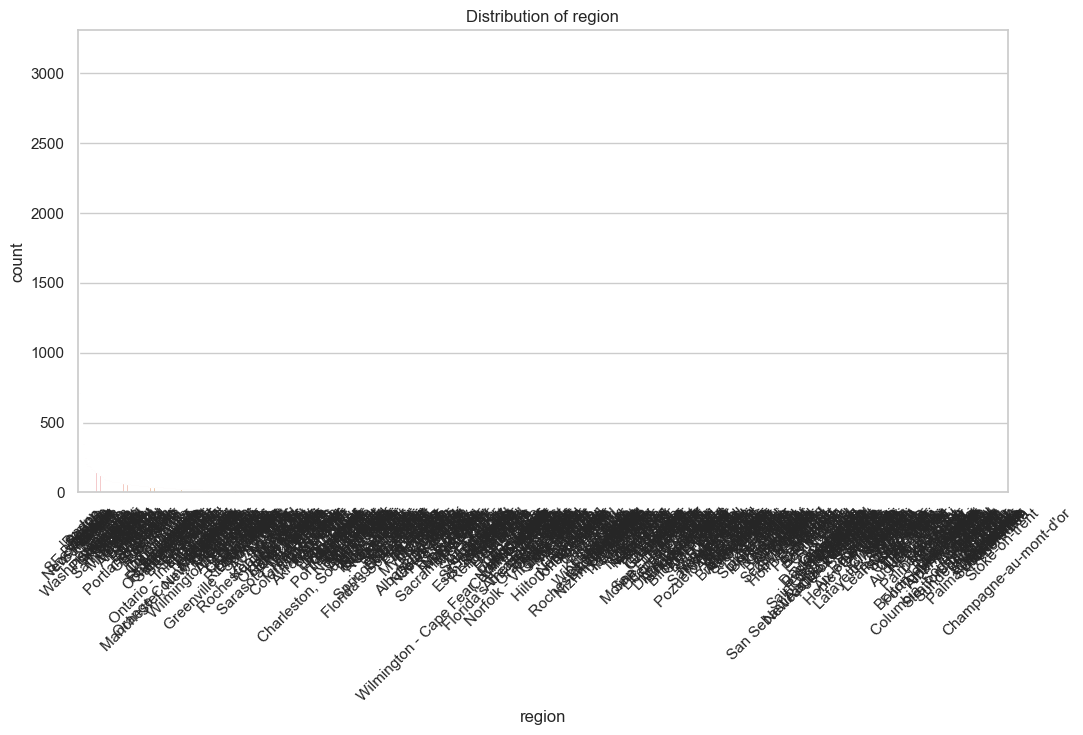

In [62]:
# Функция для построения графиков категориальных переменных
def plot_categorical_distributions(df, categorical_columns):
    for col in categorical_columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.show()

# Функция для построения графиков временных переменных
def plot_time_distributions(df, time_columns):
    for col in time_columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.show()

categorical_columns = ['funding_rounds', 'region'] #, 'state_code', 'region', 'city'] там нет смсла, очень много меток друг на друге
# time_columns = ['first_year', 'first_month', 'first_day', 'last_year', 'last_month', 'last_day']

# Построение графиков для train и test данных
for key, df in data_names.items():
    print(f'\nПостроение графиков для {key}')

    # Графики для категориальных переменных
    plot_categorical_distributions(df, categorical_columns)
    
    # Графики для временных переменных
    # plot_time_distributions(df, time_columns)

In [63]:
def top_10_frequent_values(df, columns):
    for col in columns:
        print(f"\nТоп 10 частых значений в % {col}:\n")
        top_10 = df[col].value_counts(normalize=True).head(10) * 100
        display(top_10)

columns_to_check = ['region']
top_10_frequent_values(data_names['train_copy'], columns_to_check)


Топ 10 частых значений в % region:



region
SF Bay Area         23.918425
New York City        5.286008
London               3.821692
Boston               3.598903
Los Angeles          2.881027
Seattle              1.818493
Washington, D.C.     1.555716
Chicago              1.481453
San Diego            1.338640
Tel Aviv             1.249143
Name: proportion, dtype: float64

Корреляция

In [64]:
# Функция для расчета и визуализации Phik корреляции
def calculate_phik_correlation(df_dict, sample_size):
    for key, df in df_dict.items():
        print(f"\nCalculating Phik correlation for {key}...")

        # Уменьшение размера выборки
        if len(df) > sample_size:
            df_sampled = df.sample(n=sample_size, random_state=42)
        else:
            df_sampled = df

        # Рассчитываем матрицу Phik корреляции
        phik_matrix = df_sampled.phik_matrix(interval_cols=[])

        # Визуализируем матрицу корреляций
        plot_correlation_matrix(phik_matrix.values, 
                                x_labels=phik_matrix.columns, 
                                y_labels=phik_matrix.index, 
                                vmin=-1, vmax=1, 
                                title=f"Phik Correlation Matrix for {key}")

# Применяем функцию к словарю data_names
# calculate_phik_correlation(data_names, sample_size=1000)

- Географические признаки (особенно city, region, state_code, country_code) сильно коррелируют между собой, что ожидаемо, поскольку они описывают разные уровни местоположения компании.
- funding_total_usd и lifetime также имеют высокую корреляцию с географическими признаками, что может говорить о том, что местоположение существенно влияет на эти аспекты компаний.
- При этом признаки status и funding_rounds показывают очень низкие корреляции с другими признаками, что указывает на их относительную независимость.

In [65]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    """
    Функция для расчета коэффициентов инфляции дисперсии (VIF) для DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame с признаками.

    Returns:
    pd.DataFrame: DataFrame с признаками и их соответствующими VIF значениями.
    """
    # Добавляем константу для расчета VIF
    X = sm.add_constant(df)
    
    # Вычисляем VIF для каждого признака
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Удаляем строку с константой
    vif_data = vif_data[vif_data["feature"] != "const"]
    
    return vif_data

# Применение на примере data_names['train_copy']
vif_df = calculate_vif(data_names['train_copy'].select_dtypes(include=['int64', 'float64']))
print(vif_df)

             feature       VIF
1  funding_total_usd  1.391391
2     funding_rounds  2.505967
3                e_0  1.512913
4                e_1  1.433149
5                e_2  2.207203
6                e_3  1.055112
7                e_4  1.478910
8    dur_betw_rounds  2.624664


1 < VIF < 5: Умеренная корреляция, можно принять.

In [66]:
def fill_status(series):
    return series.map({'operating':1,'closed':0})

In [67]:
train_copy_2 = data_names['train_copy'].copy(deep = True)

In [187]:
train_copy_2

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,e_0,e_1,e_2,e_3,e_4,dur_betw_rounds
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,-0.351807,1.497126,1.049809,-0.824562,0.173264,1310
1,EarLens,Manufacturing|Medical|Medical Devices,16000000.00,operating,USA,CA,SF Bay Area,Redwood City,4,1.370847,0.173515,2.959829,-0.884385,0.621324,1393
2,Reviva Pharmaceuticals,Biotechnology,16000000.00,operating,USA,CA,SF Bay Area,San Jose,3,1.714194,0.129670,2.609024,-0.866563,0.324463,681
3,Sancilio and Company,Health Care,16000000.00,operating,USA,CA,SF Bay Area,San Francisco,3,1.394429,-0.071973,3.605732,-1.098824,0.739180,1051
4,WireTough Cylinders,Manufacturing,3000000.00,operating,USA,VA,VA - Other,Bristol,1,0.270902,0.366337,2.256096,-0.378956,0.325447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,2000000.00,operating,CAN,ON,Toronto,Kitchener,1,1.244330,3.280152,0.366576,-1.200139,-0.131111,0
52512,Hello Curry,Hospitality,500000.00,operating,IND,2,Hyderabad,Hyderabad,1,-0.068941,1.282109,1.340162,-1.203620,0.637306,0
52513,Taskforce,Email|Messaging|Productivity Software,172850.75,operating,USA,CA,SF Bay Area,San Francisco,3,-0.219005,1.382196,0.451554,-0.761389,-2.041054,566
52514,NetScaler,Security,13000000.00,operating,USA,CA,SF Bay Area,San Jose,6,0.566500,0.008172,1.651052,-0.025695,-1.661142,1918


In [69]:
np.round((train_copy_2[train_copy_2['status']=='operating'].size / train_copy_2[train_copy_2['status']=='closed'].size),2)

9.68

# Pipe

In [270]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # Сохраняем названия колонок, чтобы использовать их при преобразовании в DataFrame
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns
        return self
    
    def transform(self, X):
        # Преобразуем X обратно в DataFrame, если он был преобразован в numpy.ndarray
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        X = X.copy()  # Создаем копию исходного DataFrame
        X['name'] = generate_name(X['name'])
        X = fill_missing_funding(X, group_columns=['city','country_code','state_code','region'])
        X = generate_and_fill_embeddings(X)
        X = process_date_columns(X, date_columns=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
        X = FundingRoundsBinner(column='funding_rounds').transform(X)
        X = fill_geographical_columns(X, ['city','country_code','state_code','region'])
        return X

In [271]:
# Создание пайплайнов для моделей
models = {
    'dtree': DecisionTreeClassifier(random_state=42),
    #'catboost': CatBoostClassifier(silent=True, task_type='GPU', devices='0'),
    'balanced_rf': BalancedRandomForestClassifier(random_state=42)
}
# Числовые и категориальные признаки после предобработки
numeric_features = ['funding_total_usd', 'dur_betw_rounds']
categorical_features = ['region','city','country_code','state_code','funding_rounds']
# Преобразование числовых признаков
numeric_transformer = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Или MinMaxScaler()
])

# Преобразование категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Объединение трансформеров
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создание пайплайнов для моделей с использованием Imbalanced-Learn
pipelines = {name: Pipeline(steps=[
                                ('custom_preprocessor', CustomPreprocessor()), 
                                ('preprocessor', preprocessor),
                                # ('smote', SMOTE(random_state=42)),  # Добавление SMOTE после предобработки
                                ('model', model)]) 
             for name, model in models.items()}

# Оптимизация гиперпараметров с использованием Optuna
def objective(trial):
    model_name = trial.suggest_categorical('model', list(pipelines.keys()))
    pipeline = pipelines[model_name]
    
    # Настройка гиперпараметров для моделей
    # if model_name == 'logreg':
    #     C = trial.suggest_loguniform('C', 1e-4, 1e2)
    #     penalty = trial.suggest_categorical('penalty', ['l2'])
    #     pipeline.set_params(model__C=C, model__penalty=penalty)
    # if model_name == 'catboost':
    #     depth = trial.suggest_int('depth', 4, 10)
    #     learning_rate = trial.suggest_loguniform('learning_rate', 1e-2, 1e-1)
    #     l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-2, 1e2)
    #     pipeline.set_params(model__depth=depth, 
    #                         model__learning_rate=learning_rate, 
    #                         model__l2_leaf_reg=l2_leaf_reg)
    if model_name == 'balanced_rf':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        pipeline.set_params(model__n_estimators=n_estimators, 
                            model__max_depth=max_depth,
                            model__min_samples_split=min_samples_split)
    elif model_name == 'dtree':
        criterion =  trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        pipeline.set_params(model__criterion = criterion, 
                            model__max_depth=max_depth,
                            model__min_samples_split=min_samples_split)
    
    # Кросс-валидация
    score = cross_val_score(pipeline, X_train, y_encoded, cv=5, scoring='f1').mean()
    return score

In [272]:
# Разделение данных на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(data_train.drop('status', axis=1), 
                                                    data_train['status'], 
                                                    test_size=0.2, random_state=42)
# Сохранение индекса перед трансформацией
X_train_index = X_train.index

# Пересоздание y_train после предобработки
le = LabelEncoder()
y_encoded = le.fit_transform(y_train.loc[X_train.index])

print(X_train.shape)
print(y_encoded.shape)

(42012, 12)
(42012,)


In [273]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-08-24 12:52:52,743] A new study created in memory with name: no-name-92606d02-c677-467a-af36-fba812992279
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\2981546977.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['founded_at'].fillna(overall_median_founded_at, inplace=True)
C:\Users\godcl\AppData\Local\Temp\ipykernel_16276\331704441.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. 

In [577]:
# Получение лучшей модели и гиперпараметров
best_trial = study.best_trial
print(f"Best trial: {best_trial.params}")

Best trial: {'model': 'balanced_rf', 'n_estimators': 203, 'max_depth': 15, 'min_samples_split': 7}


In [578]:
# Настройка лучшего пайплайна
best_model_name = best_trial.params['model']
best_pipeline = pipelines[best_model_name]

In [579]:
# Обучение модели на данных после применения
best_pipeline.fit(X_train, y_encoded)

C:\Users\godcl\AppData\Local\Temp\ipykernel_22476\2298103703.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['region'].fillna('unknown', inplace=True)
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\

Pipeline(steps=[('custom_preprocessor', CustomPreprocessor()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['funding_total_usd',
                                                   'lifetime']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['region',
                                                   'funding_rounds'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 BalancedRandomForestClassifier(max_depth=19,
                                                min_samples_split=6,
                                                n_estimators=145,
                                                random_state=42))])

In [580]:
y_test_pred = best_pipeline.predict(X_test)
y_t_encoded = le.transform(y_test)
# Оценка модели
print(classification_report(y_t_encoded, y_test_pred))

C:\Users\godcl\AppData\Local\Temp\ipykernel_22476\2298103703.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['region'].fillna('unknown', inplace=True)


              precision    recall  f1-score   support

           0       0.52      0.78      0.62       983
           1       0.98      0.93      0.95      9521

    accuracy                           0.91     10504
   macro avg       0.75      0.85      0.79     10504
weighted avg       0.93      0.91      0.92     10504



# Предикт на test

In [581]:
pred_data = data_names['test_copy']
y_targ = le.transform(data_samp['status'])

In [582]:
y_pred_final = best_pipeline.predict(pred_data)

C:\Users\godcl\AppData\Local\Temp\ipykernel_22476\2298103703.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['region'].fillna('unknown', inplace=True)


In [583]:
print(classification_report(y_targ, y_pred_final))

              precision    recall  f1-score   support

           0       0.49      0.15      0.22      6490
           1       0.51      0.85      0.63      6635

    accuracy                           0.50     13125
   macro avg       0.50      0.50      0.43     13125
weighted avg       0.50      0.50      0.43     13125



In [584]:
# Преобразование предсказанных значений 0 и 1 в operating и closed
y_pred_final_tr = pd.Series(y_pred_final).map({1: 'operating', 0: 'closed'})

# Преобразование реальных значений 0 и 1 обратно в operating и closed
y_test_actual_final = pd.Series(y_targ).map({1: 'operating', 0: 'closed'})

In [596]:
final_df = pd.DataFrame({
    'name': data_test['name'],
    'y_test': y_test_actual_final,
    'status': y_pred_final_tr
})
final_df = final_df.drop(columns=['y_test'])
# Вывод финального DataFrame
print(final_df.head())

                     name     status
0              Crystalsol  operating
1        JBI Fish & Wings  operating
2                COINPLUS     closed
3  Imagine Communications  operating
4                   DNA13  operating


In [598]:
final_df.to_csv('compares.csv',index = False)

# Значимость признаков

In [609]:

X_train, X_test, y_train, y_test = train_test_split(data_test, 
                                                    data_samp['status'], 
                                                    test_size=0.2, random_state=42)
custom_preprocessor = CustomPreprocessor()
X_train_preprocessed = custom_preprocessor.fit_transform(X_train)
model = best_pipeline.named_steps['model']
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train_preprocessed)

C:\Users\godcl\AppData\Local\Temp\ipykernel_22476\2298103703.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['region'].fillna('unknown', inplace=True)


In [611]:
X_train_transformed_dense = X_train_transformed.toarray()

100%|===================| 20994/21000 [08:51<00:00]        

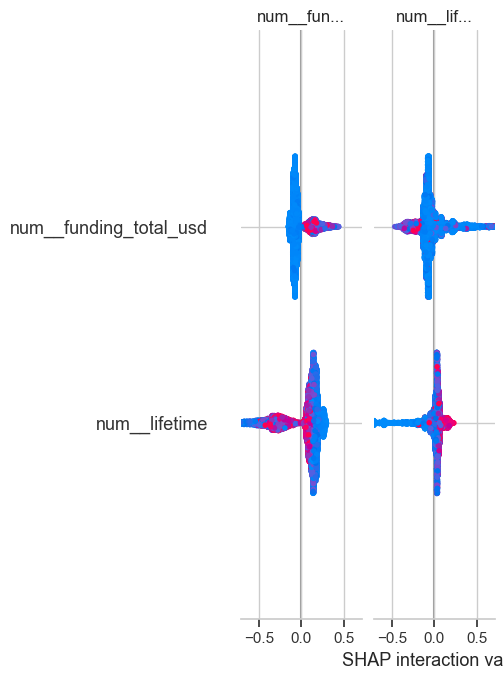

In [612]:
# Создание объяснителя для модели
explainer = shap.Explainer(model, X_train_transformed_dense)

# Вычисление SHAP значений
shap_values = explainer(X_train_transformed_dense)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_train_transformed_dense, feature_names=best_pipeline.named_steps['preprocessor'].get_feature_names_out())

Тут должен был быт нормальный шап график и анализ признаков, но я просто не успел